# Baseline model
In this notebook we explore our options for a baseline model. We also look at what preprocessing steps are needed.

In [2]:
import pandas as pd
import numpy as np
import os

RANDOM_SEED = 21223

Unzip dataset

In [3]:
from zipfile import ZipFile
dir_path = "../data"
train_path = dir_path + "/asl_train"
test_path = dir_path + "/asl_test"

def unzip_if_not_exists(zip_file_path, extract_to_path):
    # check if the target directory already exists
    if not os.path.exists(extract_to_path):
        # create the directory if it doesn't exist
        os.makedirs(extract_to_path)
        # unzip the contents
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully unzipped to {extract_to_path}")
    else:
        print(f"The directory {extract_to_path} already exists. Skipped unzipping.")

unzip_if_not_exists(dir_path + "/asl_alphabet_train.zip", train_path)
unzip_if_not_exists(dir_path + "/asl_alphabet_test.zip", test_path)

The directory ../data/asl_train already exists. Skipped unzipping.
The directory ../data/asl_test already exists. Skipped unzipping.


Store all data in a pandas df

In [4]:
train_path += "/asl_alphabet_train/"
test_path += "/asl_alphabet_test/"

# map alphabet to numbers
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "K",
                10: "L",
                11: "M",
                12: "N",
                13: "O",
                14: "P",
                15: "Q",
                16: "R",
                17: "S",
                18: "T",
                19: "U",
                20: "V",
                21: "W",
                22: "X",
                23: "Y",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df

# store all the file names in the dataset
filenames = []
# store the corresponding class for each file
target = []

for category in categories:
    files = os.listdir(train_path + categories[category])
    filenames += files
    target += [category] * len(files)

df = pd.DataFrame({"filename": filenames, "category": target})
df = add_class_name_prefix(df, "filename")

# shuffle the dataframe
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

check it out

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  72000 non-null  object
 1   category  72000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,filename,category
0,V1957.jpg,20
1,M2695.jpg,11
2,C705.jpg,2
3,T1148.jpg,18
4,P600.jpg,14


sample a smaller dataset. split into train and test.

In [6]:
n = 100
n_train = int(n*0.8)

# sample n random data points from each sign class
df_small = df.groupby('category', group_keys=False).apply(lambda x: x.sample(n, ignore_index=True, random_state=RANDOM_SEED))

# sample n_train % of the small df for the train set
df_train = df.groupby('category', group_keys=False).apply(lambda x: x.sample(n_train, ignore_index=True, random_state=RANDOM_SEED))

# shuffle train set
df_train = df_train.sample(frac=1).reset_index(drop=True)

# obtain test set from remaining points in the small df
df_test = pd.merge(df_small, df_train, how='left', indicator=True)
df_test = df_test[df_test['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(1920, 2)
(480, 2)


Preprocessing steps:
- Grayscale
- Flatten to 1D
- Normalize pixel values to 0-1
- Feature extraction/Dimensionality reduction -> TBD

In [7]:
from PIL import Image

# preprocess each row in the dataframes
def process_row(row):
    filename = row["filename"]
    label = row["category"]
    # load
    image = Image.open(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = image.convert('L')
    # convert to 2d tensor
    image_arr = np.array(gray_image)
    # normalize to 0-1 range
    normalized_arr = image_arr / 255
    # flatten 2d tensor to 1d array
    flat_image = normalized_arr.ravel()
    new_row = {'image_array': flat_image, 'label': label}
    return new_row

df_train_processed = df_train.apply(process_row, axis=1, result_type="expand")
df_test_processed = df_test.apply(process_row, axis=1, result_type="expand")

In [8]:
df_train_processed.head(2)

,image_array,label
0,"[0.12549019607843137, 0.11764705882352941, 0.1...",6
1,"[0.11764705882352941, 0.11764705882352941, 0.1...",19


extract X and y from df

In [39]:
X_train = np.array(df_train_processed['image_array'].tolist())
y_train = np.array(df_train_processed['label'])

X_test = np.array(df_test_processed['image_array'].tolist())
y_test = np.array(df_test_processed['label'])

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1920
1920
480
480


at this point we have 1D arrays of all 40k pixels for each image

we'll try training an autoencoder on these to obtain an encoding to feed to our baseline

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

original_dim = 200*200

autoencoder = Sequential([
    Dense(2048, activation='relu',  input_shape=(original_dim,)),
    #Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    #Dense(256, activation='relu'),
    Dense(144, activation='relu'),
    #Dense(64, activation='relu'),
    #Dense(128, activation='relu'),
    #Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    #Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 2048)              81922048  
                                                                 
 dense_29 (Dense)            (None, 512)               1049088   
                                                                 
 dense_30 (Dense)            (None, 144)               73872     
                                                                 
 dense_31 (Dense)            (None, 512)               74240     
                                                                 
 dense_32 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_33 (Dense)            (None, 40000)             81960000  
                                                                 
Total params: 166,129,872
Trainable params: 166,129,8

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=100,  
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
48/48 [==============================] - 75s 2s/step - loss: 0.0354 - val_loss: 0.0213
Epoch 2/100
48/48 [==============================] - 79s 2s/step - loss: 0.0185 - val_loss: 0.0153
Epoch 3/100
48/48 [==============================] - 62s 1s/step - loss: 0.0153 - val_loss: 0.0141
Epoch 4/100
48/48 [==============================] - 39s 811ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 5/100
48/48 [==============================] - 46s 954ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 6/100
48/48 [==============================] - 50s 1s/step - loss: 0.0120 - val_loss: 0.0122
Epoch 7/100
48/48 [==============================] - 42s 868ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 8/100
48/48 [==============================] - 47s 989ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 9/100
48/48 [==============================] - 40s 833ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 10/100
48/48 [==============================] - 46s 961ms/step - loss: 0.0100 - val_loss

we check for overfitting

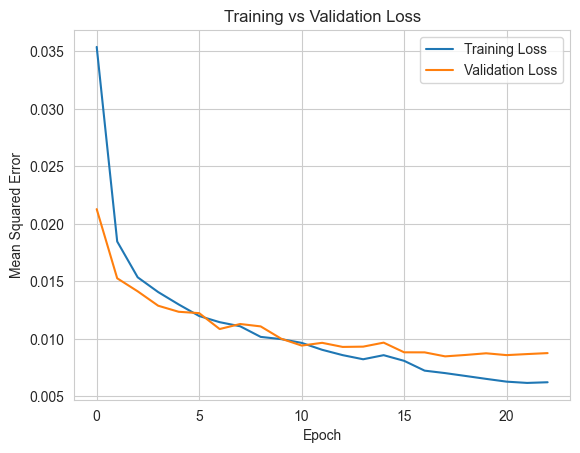

In [47]:
import matplotlib.pyplot as plt

# plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

now we supposedly obtained a 64D meaningful representation of the pictures. we'll use this to train an SVM

In [48]:
encoder = Sequential(autoencoder.layers[:3]) 
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

15/15 [==============================] - 1s 34ms/step


let's see what a random image from the train set looks like originally and what it looks like encoded

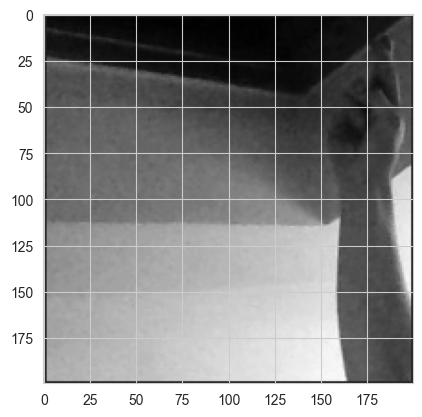

In [52]:
plt.imshow(X_train[6].reshape((200,200)), cmap='gray')

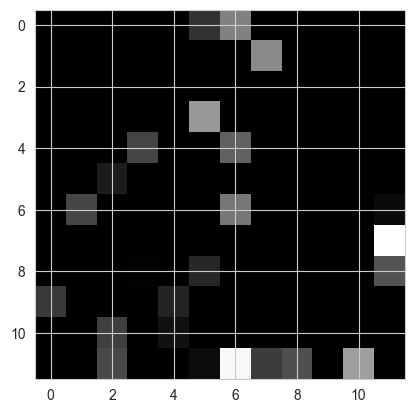

In [53]:
plt.imshow(X_train_encoded[6].reshape((12,12)), cmap='gray')

60/60 [==============================] - 3s 32ms/step


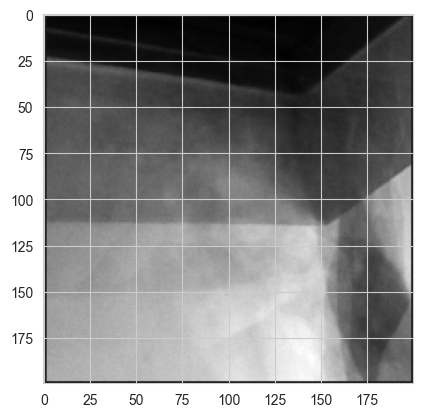

In [54]:
decoder = Sequential(autoencoder.layers[3:6]) 
X_train_decoded = decoder.predict(X_train_encoded)

plt.imshow(X_train_decoded[6].reshape((200,200)), cmap='gray')

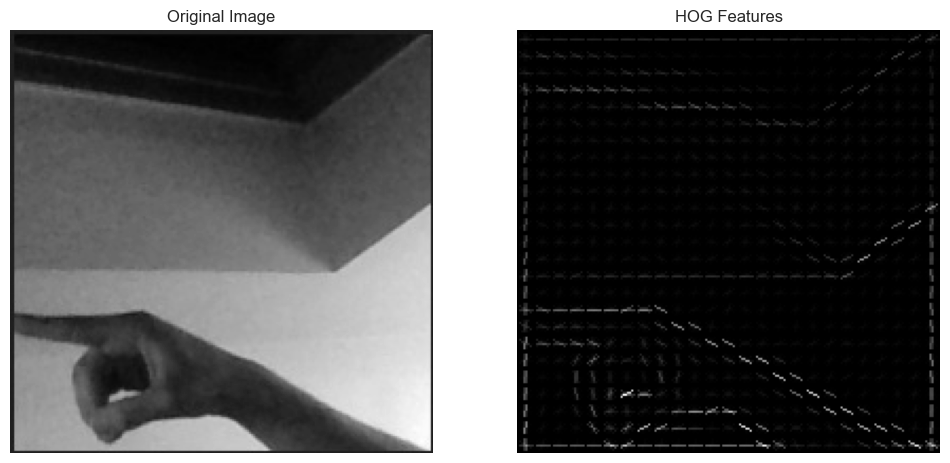

In [56]:
from skimage import data, exposure, feature

img = X_train[5].reshape((200,200))

# Calculate HOG features
hog_features, hog_image = feature.hog(img, visualize=True)

# Visualize the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Original Image')

# Visualize the HOG features
ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('HOG Features')

plt.show()

1/1 [==============================] - 1s 1s/step


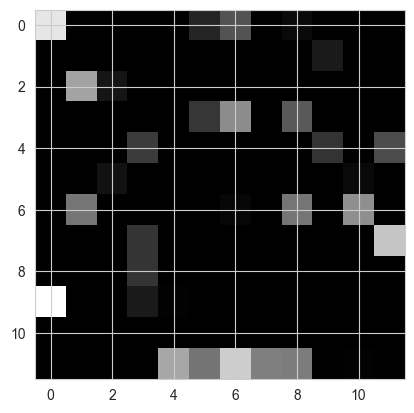

In [61]:
encoded_sample = encoder.predict(np.array([hog_image.reshape(-1)]))
plt.imshow(encoded_sample[0].reshape((12,12)), cmap='gray')

1/1 [==============================] - 1s 1s/step


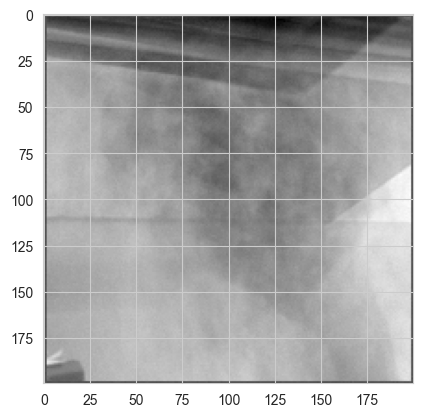

In [62]:
decoded_sample = decoder.predict([encoded_sample])
plt.imshow(decoded_sample[0].reshape((200,200)), cmap='gray')

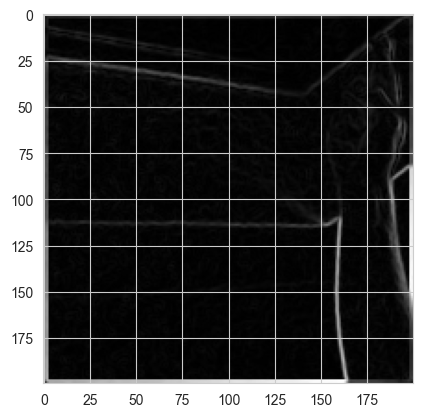

In [65]:
from skimage import filters

img = X_train[6].reshape((200,200))

sobel_edges = filters.sobel(img)
plt.imshow(sobel_edges, cmap=plt.cm.gray)

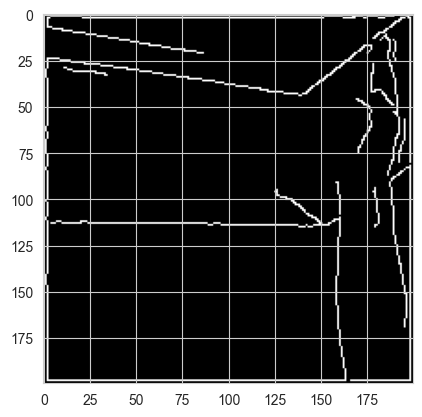

In [66]:
canny_edges = feature.canny(img)
plt.imshow(canny_edges, cmap=plt.cm.gray)

from this point on i try to autoencode the canny edges

(1920, 40000)


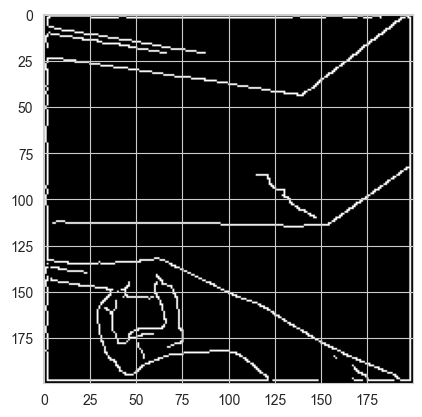

In [119]:
X_train_canny = np.array([feature.canny(im.reshape((200,200))).reshape(-1) for im in X_train])
print(X_train_canny.shape)
plt.imshow(X_train_canny[5].reshape((200,200)), cmap=plt.cm.gray)

brief intermission with resampling (fail)

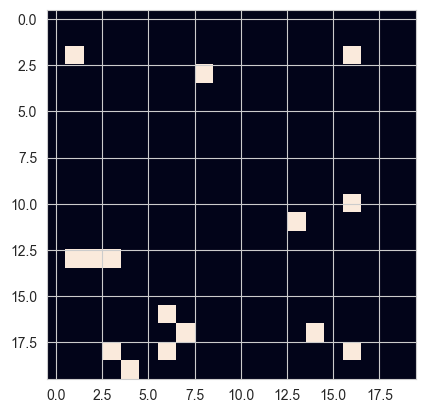

In [85]:
from PIL.Image import Resampling
from PIL import Image

img = X_train_canny[5].reshape((200,200))
im = Image.fromarray(np.uint8(img))
resized = im.resize((20,20), resample=Resampling.NEAREST)
plt.imshow(resized)

In [120]:
canny_history = autoencoder.fit(
    X_train_canny,
    X_train_canny,
    epochs=100,  
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
48/48 [==============================] - 43s 833ms/step - loss: 0.0551 - val_loss: 0.0475
Epoch 2/100
48/48 [==============================] - 53s 1s/step - loss: 0.0485 - val_loss: 0.0475
Epoch 3/100
48/48 [==============================] - 52s 1s/step - loss: 0.0485 - val_loss: 0.0475
Epoch 4/100
48/48 [==============================] - 51s 1s/step - loss: 0.0485 - val_loss: 0.0475
Epoch 5/100
48/48 [==============================] - 27s 560ms/step - loss: 0.0485 - val_loss: 0.0475
Epoch 6/100
48/48 [==============================] - 45s 932ms/step - loss: 0.0485 - val_loss: 0.0475


In [122]:
canny_encoder = Sequential(autoencoder.layers[:3]) 
X_train_canny_encoded = encoder.predict(X_train)

canny_decoder = Sequential(autoencoder.layers[3:6]) 
X_train_canny_decoded = decoder.predict(X_train_canny_encoded)

60/60 [==============================] - 2s 29ms/step


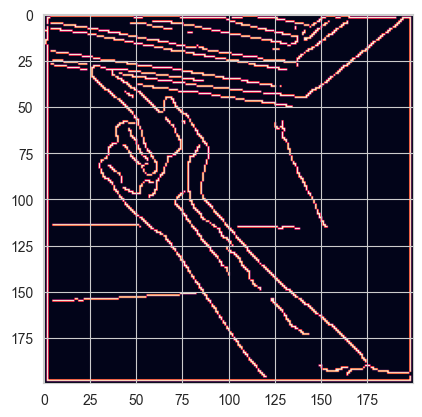

In [127]:
idx = 0
img = X_train_canny[idx]
img_encoded = X_train_canny_encoded[idx]
img_decoded = X_train_canny_decoded[idx]

plt.imshow(img.reshape((200,200)))

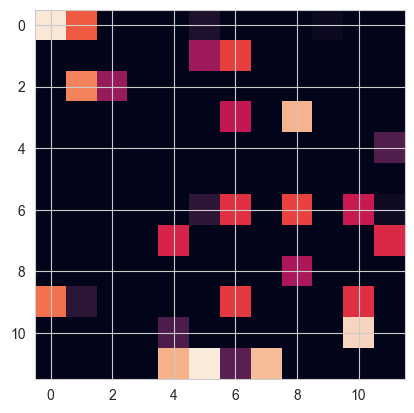

In [128]:
plt.imshow(img_encoded.reshape((12,12)))

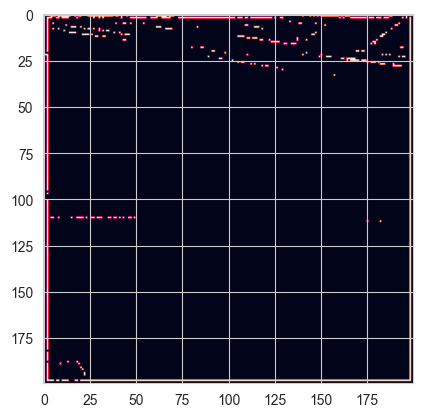

In [129]:
plt.imshow(img_decoded.reshape((200,200)))

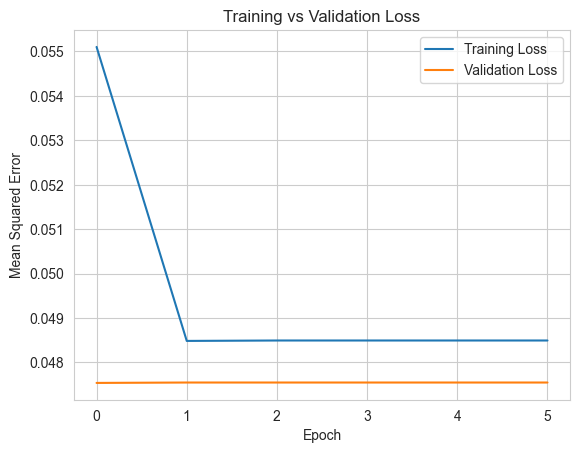

In [130]:
plt.plot(canny_history.history['loss'], label='Training Loss')
plt.plot(canny_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()